# Example using PyStan

Here's an example of using [PyStan](http://pystan.readthedocs.io/en/latest/) to fit a linear model with a Gaussian likelihood.

In [1]:
%matplotlib inline

import numpy as np
import pystan

import corner

In [2]:
# set true gradient and y-intercept for a linear model
m = 3.5 # gradient
c = 1.2 # y-intercept

# set the "predictor variable"/abscissa
x = np.linspace(0., 10., 100) # 100 points linearly spaced between 0 and 10

# create some "data" - the model plus Gaussian noise
sigma = 0.4 # standard deviation of noise
y = m*x + c + np.random.randn(len(x))*sigma

In [3]:
line_code = """
data {{
    int<lower=0> N;  // number of data points
    real y[N];       // observed data points
    real x[N];       // abscissa points
    real<lower=0> sigma; // standard deviation
    //real<lower=0> sigma[N]; // standard deviations (do this for difference sigmas for each point)
}}
parameters {{
    // parameters for the fit
    real m;
    real c;
}}
transformed parameters {{
    real theta[N];
    for (j in 1:N)
    theta[j] = m * x[j] + c; // straight line model
}}
model {{
    m ~ uniform({mlower}, {mupper}); // prior on m (gradient)
    c ~ uniform({clower}, {cupper}); // prior on c (y-intercept)
    y ~ normal(theta, sigma);        // likelihood of the data given the model
}}
"""

# set the data and the abscissa
linear_data = {'N': len(y),              # number of data points
               'y': y.tolist(),          # observed data
               'x': x.tolist(),          # abscissa points
               'sigma': sigma}           # single standard deviation
               #'sigma': [sigma]*len(y)}  # standard deviations (do this for multiple standard deviations)

# dictionary for inputs into line_code
linedict = {}
linedict['mlower'] = -10 # lower bound on uniform prior distribution for m
linedict['mupper'] = 10  # upper bound on uniform prior distribution for m
linedict['clower'] = -10 # lower bound on uniform prior distribution for c
linedict['cupper'] = 10  # upper bound on uniform prior distribution for c

sm = pystan.StanModel(model_code=line_code.format(**linedict)) # compile model
fit = sm.sampling(data=linear_data, iter=1000, chains=4)       # perform sampling

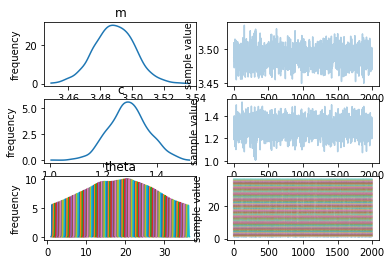

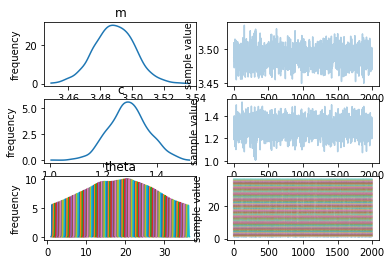

In [4]:
# show PyStan's default plot
fit.plot()

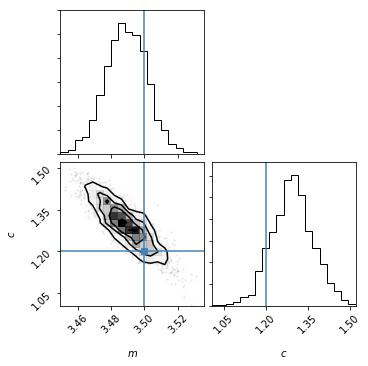

In [6]:
la = fit.extract(permuted=True)  # return a dictionary of arrays
mchain = la['m']
cchain = la['c']

# plot using corner.py
fig = corner.corner(np.array([mchain, cchain]).T, labels=[r'$m$', r'$c$'], truths=[m, c])